Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
rlimits = {}
rlimits['g'] = 1, 8, np.inf
rlimits['r'] = 1, 7, np.inf
rlimits['z'] = 1, 7, np.inf

field = 'south'
output_name = 'decals_ngc'

poly_all = []

--------------------------------------------------------------------------------------
south decals_ngc g-band
         5          4         3         2
-0.2537 x + 0.2668 x + 1.461 x - 1.998 x - 3.398 x - 2.236


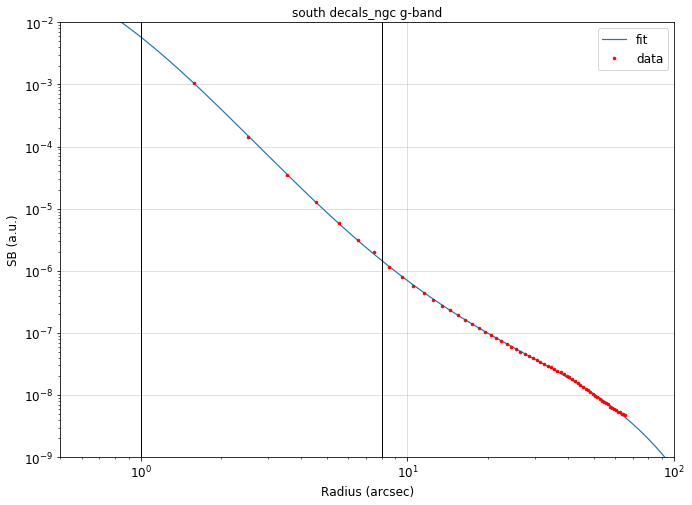

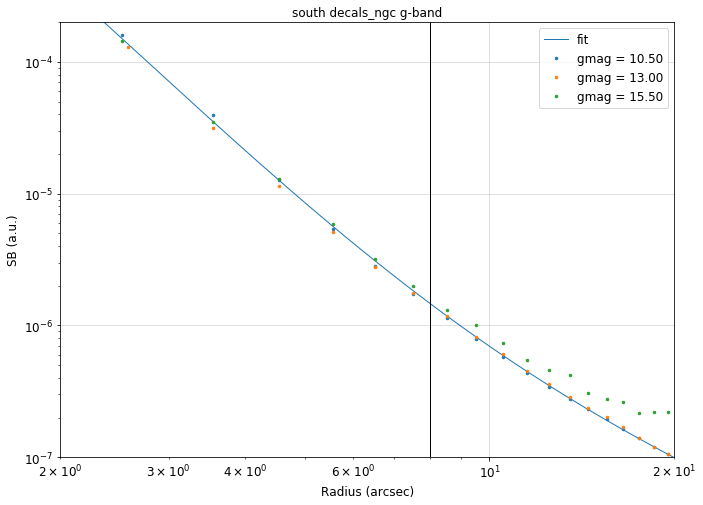

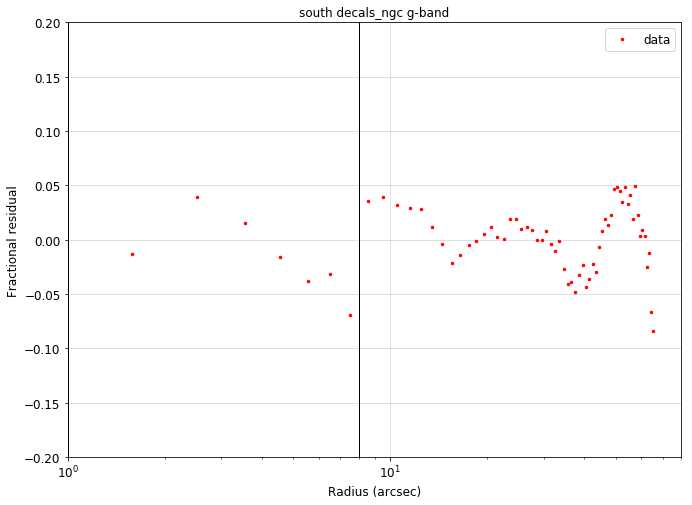

--------------------------------------------------------------------------------------
south decals_ngc r-band
          5          4        3         2
-0.02683 x - 0.4871 x + 2.31 x - 2.605 x - 2.965 x - 2.392


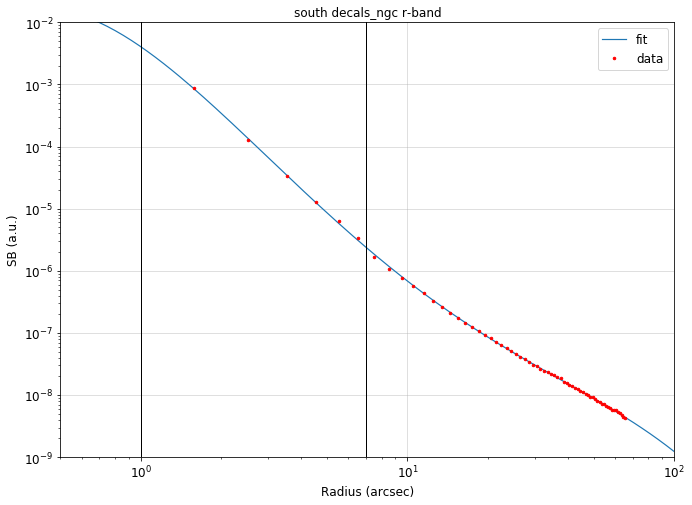

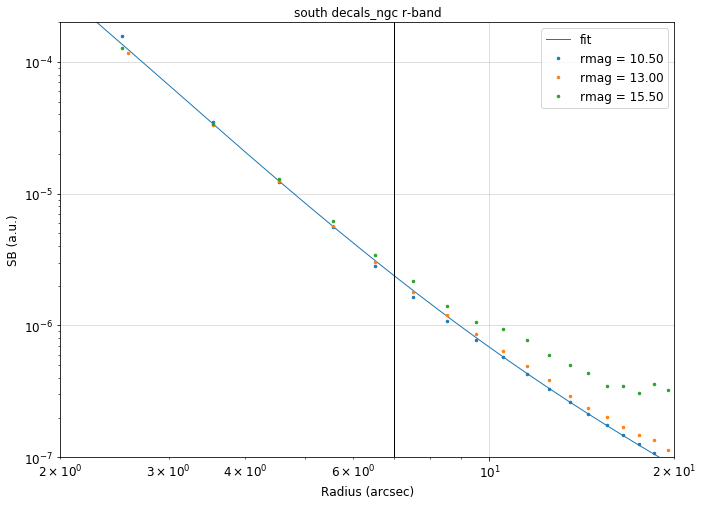

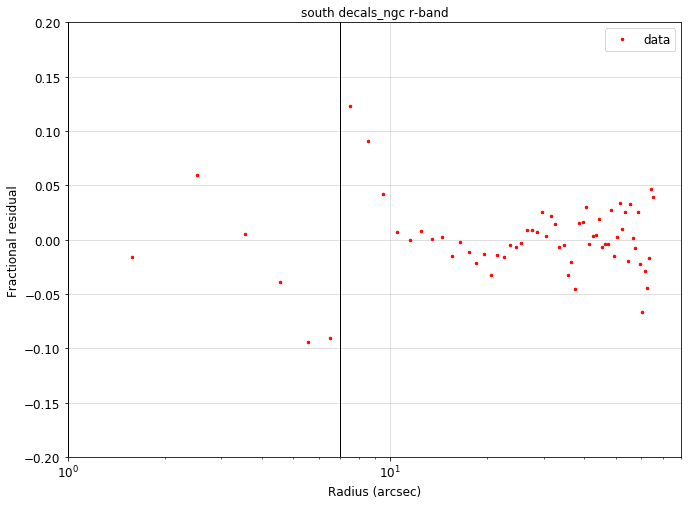

--------------------------------------------------------------------------------------
south decals_ngc z-band
       5         4         3         2
1.439 x - 7.969 x + 16.01 x - 13.63 x + 1.185 x - 2.865


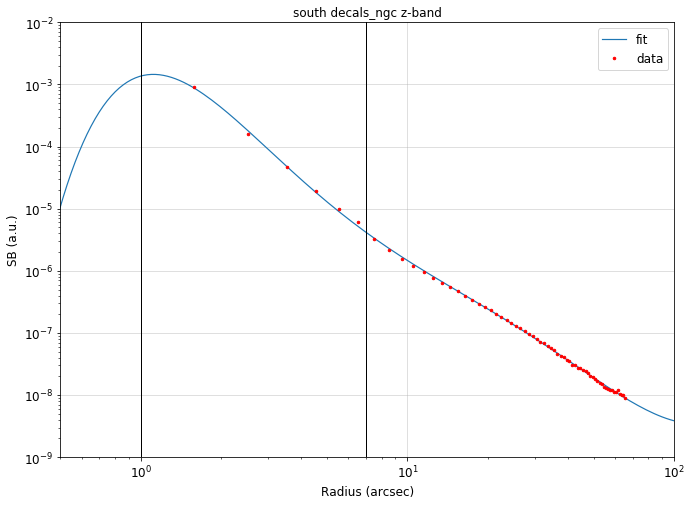

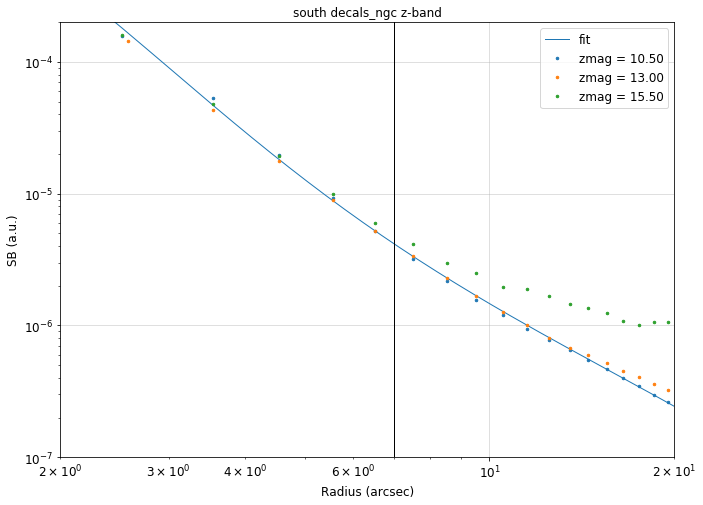

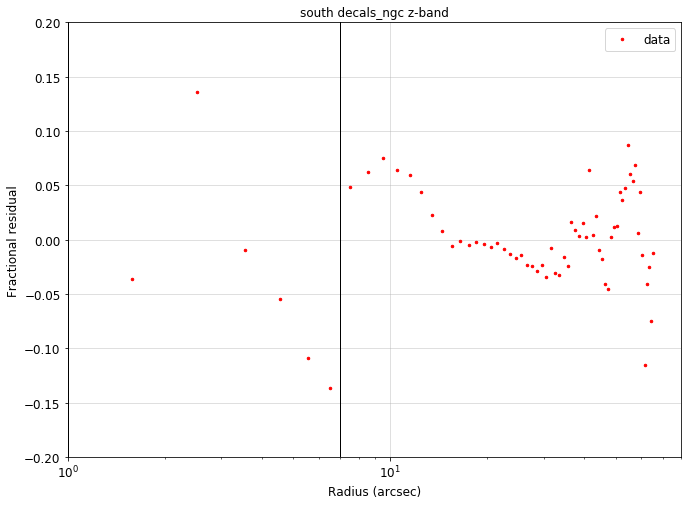

In [12]:
for band in ['g', 'r', 'z']:
    
    print('--------------------------------------------------------------------------------------')
    print('{} {} {}-band'.format(field, output_name, band))
    
    if (field=='north') and ((band=='g') or (band=='r')):
        pixscale_native = 0.454
    else:
        pixscale_native = 0.262
    # pixscale = 0.262 # pixscale for cutout queries

    ls_mag_bins = [10.5, 11.75, 13.0, 14.25, 15.5]

    # rmin, rsep, rmax = 1, 9, np.inf
    rmin, rsep, rmax = rlimits[band]

    ##############################################################################

    profile = Table.read('../data/average_profiles_{}_{}_{}.txt'.format(field, output_name, band), format='ascii.commented_header')
    indiv = Table.read('../data/individual_profiles_{}_{}_{}.fits'.format(field, output_name, band))

    # stitch together the profiles of two magnitude bins
    index = -1
    norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
    x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    mask = (x>rmin) & (x<rsep)
    xdata = x[mask]
    ydata = y[mask]

    index = 0
    norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
    x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
    mask = (x>=rsep) & (x<np.inf)
    xdata = np.concatenate((xdata, x[mask]))
    ydata = np.concatenate((ydata, y[mask]))

    ##############################################################################
    # 5th-order polynomial

    xlog, ylog = np.log10(xdata), np.log10(ydata)
    poly = np.polyfit(xlog, ylog, deg=5)
    poly_all.append(poly)
    profile_fit = np.poly1d(poly)
    print(profile_fit)

    # xfit = np.linspace(0.1, 300, 2000)
    xfit = np.logspace(-1, 2, 200)
    yfit = 10**(profile_fit(np.log10(xfit)))

    plt.figure(figsize=(11, 8))
    plt.loglog(xfit, yfit, '-', lw=1.2, alpha=1., 
               label='fit', c='C0')
    plt.loglog(xdata, ydata, '.', lw=1.2, alpha=1., ms=5.,
               label='data', c='r')
    plt.title('{} {} {}-band'.format(field, output_name, band))
    plt.axis([0.5, 100, 1e-9, 1e-2])
    plt.grid(alpha=0.5)
    plt.xlabel('Radius (arcsec)')
    plt.ylabel('SB (a.u.)')
    plt.axvline(rmin, lw=1, color='k')
    plt.axvline(rsep, lw=1, color='k')
    plt.legend()
    plt.show()

    plt.figure(figsize=(11, 8))
    plt.loglog(xfit, yfit, '-', lw=1., alpha=1., 
               label='fit', c='C0')
    # for index in range(len(ls_mag_bins)):
    for index in [0, 2, 4]:
        # normalize the flux to 22.5 magnitude stars
        norm = 10**((ls_mag_bins[index]-22.5)/2.5) * pixscale_native**2
        x = profile['radius_{}_{:.2f}'.format(band, ls_mag_bins[index])]
        y = norm * profile['flux_{}_{:.2f}'.format(band, ls_mag_bins[index])]
        plt.loglog(x, y, '.', lw=1.2, alpha=1., ms=5.,
                   label='{}mag = {:.2f}'.format(band, ls_mag_bins[index]))
    plt.title('{} {} {}-band'.format(field, output_name, band))
    plt.axis([2, 20, 1e-7, 2e-4])
    plt.axvline(rmin, lw=1, color='k')
    plt.axvline(rsep, lw=1, color='k')
    plt.grid(alpha=0.5)
    plt.xlabel('Radius (arcsec)')
    plt.ylabel('SB (a.u.)')
    plt.legend()
    plt.show()

    ydata_fit = 10**(profile_fit(np.log10(xdata)))
    plt.figure(figsize=(11, 8))
    plt.semilogx(xdata, (ydata_fit-ydata)/ydata, '.', lw=1.2, alpha=1., ms=5.,
               label='data', c='r')
    plt.title('{} {} {}-band'.format(field, output_name, band))
    plt.axis([1, 80, -0.2, 0.2])
    plt.grid(alpha=0.5)
    plt.xlabel('Radius (arcsec)')
    plt.ylabel('Fractional residual')
    plt.axvline(rmin, lw=1, color='k')
    plt.axvline(rsep, lw=1, color='k')
    plt.legend()
    plt.show()

In [5]:
for index, band in enumerate(['g', 'r', 'z']):
    print(band, poly_all[index])

g [-0.25374275  0.2667515   1.4606936  -1.99823195 -3.39780119 -2.23553798]
r [-0.02682569 -0.4871116   2.31043612 -2.60471433 -2.96514646 -2.39183566]
z [  1.4393356   -7.96924951  16.0064581  -13.63062087   1.18527603
  -2.86520728]


In [7]:
np.savetxt('../data/{}_poly_fit.txt'.format(output_name), poly_all)